In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:75% !important; }</style>"))

In [2]:
import sys

sys.path.insert(0, '/media/rich/Home_Linux_partition1/github_repos/tensorly')

import numpy as np

# Import PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# # Import TensorLy
# import tensorly as tl
# from tensorly.tucker_tensor import tucker_to_tensor
# from tensorly.random import check_random_state

In [3]:
sys.path.insert(0, '/media/rich/Home_Linux_partition/github_repos/tensorly')

import tensorly as tl
import tensorly.decomposition
import tensorly.random


In [4]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import tensorly; print("TensorLy", tensorly.__version__)
import torch; print("PyTorch", torch.__version__)

Linux-5.4.0-54-generic-x86_64-with-glibc2.10
Python 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
NumPy 1.19.2
SciPy 1.5.2
TensorLy 0.5.0
PyTorch 1.7.0


In [5]:
tl.set_backend('pytorch')

In [6]:
random_state = 1234
rng = tensorly.random.check_random_state(random_state)
device = 'cuda:0'
# device = 'cpu'

In [7]:
# ### import data

# dir_factors_np = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
# fileName_factors_np = f'factors_np.npy'
# path_factors_np = f'{dir_factors_np}/{fileName_factors_np}'
# factors_np = np.load(path_factors_np , allow_pickle=True)
# print(f'inputTensor shape: {factors_np.shape}')

In [8]:
### import data

dir_inputTensor = f'/media/rich/bigSSD RH/res2p/Camera data/round 4 experiments/mouse 6.28/20201102/cam3/run3'
fileName_inputTensor = f'Sxx_allPixels.npy'
path_inputTensor = f'{dir_inputTensor}/{fileName_inputTensor}'
inputTensor = np.load(path_inputTensor)
print(f'inputTensor shape: {inputTensor.shape}')

inputTensor shape: (820, 49, 29323, 2)


In [9]:
# # tensor = tl.tensor(inputTensor[:,:,:4500, :] , device=device , dtype=tl.float32 , requires_grad=True)
# tensor = torch.tensor(inputTensor[:,:,:4500, :] , device=device , dtype=tl.float32 , requires_grad=True)
# # tensor = tl.tensor(tensor[ , device=device , requires_grad=True)

import gc

del inputTensor
gc.collect()

In [10]:
rank_toUse = 6
ranks = [rank_toUse , rank_toUse, rank_toUse , rank_toUse]
# core = tl.tensor(rng.random_sample(ranks), device=device, requires_grad=True)

# factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])),
#                  device=device, requires_grad=True) for i in range(tl.ndim(tensor))]

weights = tl.tensor(np.ones(rank_toUse) , device=device, dtype=tl.float32, requires_grad=True)
# weights = tl.tensor(np.ones(rank_toUse) , device="cuda:0", dtype=tl.float32, requires_grad=True)

In [11]:
from torch.utils.data import Dataset, DataLoader
import copy

# class FaceLandmarksDataset(Dataset):
#     """Face Landmarks dataset."""

#     def __init__(self, csv_file, root_dir, transform=None):
#         """
#         Args:
#             csv_file (string): Path to the csv file with annotations.
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied
#                 on a sample.
#         """
#         self.landmarks_frame = pd.read_csv(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.landmarks_frame)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_name = os.path.join(self.root_dir,
#                                 self.landmarks_frame.iloc[idx, 0])
#         image = io.imread(img_name)
#         landmarks = self.landmarks_frame.iloc[idx, 1:]
#         landmarks = np.array([landmarks])
#         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'landmarks': landmarks}

#         if self.transform:
#             sample = self.transform(sample)

#         return sample
    
    
    
### Make dataset objects

class make_batchSlices_dataObj(Dataset):
    def __init__(self, input_tensor):
        """
        Args:
            input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
        """
        self.tensor_full = input_tensor
    def __len__(self):
        return self.tensor_full.shape[2]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()        
        tensor_slice = torch.tensor( self.tensor_full[:,:,idx,:] , dtype=torch.float32 , device=device , requires_grad=True )
        return tensor_slice , idx
    
class make_batchFilaments_dataObj(Dataset):
    def __init__(self, input_tensor):
        """
        Args:
            input_tensor (tensor type): for now, this is a variable (in the memory) that should be pre-loaded in
        """
        self.tensor_full = input_tensor
        self.shape_tensor = self.tensor_full.shape
    def __len__(self):
        return self.shape_tensor[0] * self.shape_tensor[1] * self.shape_tensor[3]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()     
        idx_subscripts = np.unravel_index([idx], (batchFilaments_dataObj.shape_tensor[0] , batchFilaments_dataObj.shape_tensor[1] , batchFilaments_dataObj.shape_tensor[3]) , order='F') # order='F' necessary to make it (dim 0 , dim1 , dim2, ...)
        idx_subscripts = np.array(idx_subscripts)[:,0]
        
        tensor_filament = torch.tensor( self.tensor_full[idx_subscripts[0],idx_subscripts[1],:,idx_subscripts[2]] , dtype=torch.float32 , device=device , requires_grad=True )
        return tensor_filament , idx , idx_subscripts

In [12]:
batch_size = 1000

batchSlices_dataObj = make_batchSlices_dataObj(inputTensor)
dataloader_batchSlices = DataLoader(batchSlices_dataObj, batch_size=7000, drop_last=False,
                        shuffle=True, num_workers=0)
batchFilaments_dataObj = make_batchFilaments_dataObj(inputTensor)
dataloader_batchFilaments = DataLoader(batchFilaments_dataObj, batch_size=1, drop_last=True,
                        shuffle=True, num_workers=0)

In [14]:
#basic libary
import torch

import torch.nn as nn
import torch.optim as optim

import time
# torch.multiprocessing.set_start_method('spawn')# good solution !!!!

##Define Function and class to be used
eps = 1.3e-7  # Slightly higher than min value of fp32
prox_plus = nn.Threshold(0,eps) ## to make all output postive 

class NTF(nn.Module): ## Model
    def __init__(self):
        super(NTF, self).__init__()

#         self.factors = nn.ParameterList([nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[i], ranks[i])) , device='cuda:0').double(), requires_grad=True) for i in range(tensor.ndim)])
        
#         self.factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])), device='cuda:0', requires_grad=True) for i in range(tl.ndim(tensor))]

           
        self.factors1 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[0], ranks[0])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors2 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[1], ranks[1])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors3 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[2], ranks[2])) , dtype=tl.float32 , device=device), requires_grad=True) 
        self.factors4 = nn.Parameter(torch.tensor(rng.random_sample((inputTensor.shape[3], ranks[3])) , dtype=tl.float32 , device=device), requires_grad=True) 
        
    def forward(self , stage , idx):
        # if 'batchSlices' then idx should be scalar
        # if 'batchFilaments' then idx should be 3-tuple or 3-value array
#     def forward(self):

#         return prox_plus(tl.cp_tensor.cp_to_tensor((weights, list([ torch.tensor(task1.factors[i]) for i in range(tensor.ndim) ])))).double()
#         return prox_plus(tl.cp_tensor.cp_to_tensor((weights, self.factors))).double()

#         self.factors1 = nn.Parameter( self.factors1 - self.factors1*(self.factors1 <=eps)  +  eps*(self.factors1 <=eps))
#         self.factors2 = nn.Parameter( self.factors2 - self.factors2*(self.factors2 <=eps)  +  eps*(self.factors2 <=eps))
#         self.factors3 = nn.Parameter( self.factors3 - self.factors3*(self.factors3 <=eps)  +  eps*(self.factors3 <=eps))
#         self.factors4 = nn.Parameter( self.factors4 - self.factors4*(self.factors4 <=eps)  +  eps*(self.factors4 <=eps))
        if stage=='batchFilaments':
            tmp = list((self.factors3.relu() , self.factors1[idx[:,0],:].relu() , self.factors2[idx[:,1],:].relu() , self.factors4[idx[:,2],:].relu()))
        if stage=='batchSlices':
#             tmp = list((self.factors3.relu() , self.factors1.relu() , self.factors2.relu() , self.factors4.relu()))
#             tmp = list((self.factors3[idx,:].relu() , self.factors1.relu() , self.factors2.relu() , self.factors4.relu()))
#             tmp = list((self.factors3[idx,:] , self.factors1 , self.factors2 , self.factors4))
            tmp = list((prox_plus(self.factors3[idx,:]) , prox_plus(self.factors1) , prox_plus(self.factors2) , prox_plus(self.factors4)))
        
        
#         tmp = list((self.factors1.relu() , self.factors2.relu() , self.factors3.relu() , self.factors4.relu()))
#         tmp = list((self.factors3.relu() , self.factors1.relu() , self.factors2.relu()  , self.factors4.relu()))
#         tmp = list((self.factors1 , self.factors2 , self.factors3 , self.factors4))
        
#         reconstruction = prox_plus(tl.cp_tensor.cp_to_tensor((weights, tmp)))
        reconstruction = tl.cp_tensor.cp_to_tensor((weights, tmp))
#         print(reconstruction.shape)
        return reconstruction
#         return tl.cp_tensor.cp_to_tensor((weights, tmp))


class NonNegativeClipper(object):
    def __init__(self, frequency=50):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        
        for param in module.parameters():
            param.data.sub_(param*(param<=0) - eps*1)
            
            
print('Start training on Task 1...')

# goal_tensor = tensor

ntf_obj = NTF()
loss_rolling=[] #collect loss

n_epoch =5000
# lr = 0.005
lr = 0.01
# lr = 0.2
penalty_L1 = 0.1
penalty_L2 = 0.1
weight_decay = 0.2
# loss_fn = nn.MSELoss(reduction='sum')


# optimizer = optim.SGD(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr)
optimizer    = torch.optim.Adam(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4))  ,  lr=lr , weight_decay=weight_decay)

clipper = NonNegativeClipper()

for epoch in range(n_epoch):
#     torch.cuda.empty_cache()
    stage='batchSlices'
    ntf_obj.factors1.requires_grad = True
    ntf_obj.factors2.requires_grad = True
    ntf_obj.factors3.requires_grad = True
    ntf_obj.factors4.requires_grad = True
    for n_iter_batchSlices , (tensor_batchSlices, idx_batchSlices)   in   enumerate(dataloader_batchSlices):
        for idx, p in enumerate(ntf_obj.factors3):
            if idx not in idx_batchSlices:
                p.requires_grad = False
        for iter_repeats in range(1000):
            Y_ = ntf_obj(stage , idx_batchSlices)
            loss = tl.norm((Y_ - tensor_batchSlices), 2)
#             # squared l2 penalty on the factors of the decomposition
#             for param in ntf_obj.parameters():
#         #         loss = loss + penalty_L2 * param.data.pow(2).sum()
#         #         loss = loss + penalty_L2 * param.data.abs().sum()
#                 l1_regularization = penalty_L1 * torch.norm(param.data, 1)
#                 l2_regularization = penalty_L2 * (torch.norm(param.data, 2)**2)
#                 loss = loss + l1_regularization + l2_regularization
            ntf_obj.zero_grad() # need to clear the old gradients
            loss.backward(retain_graph=True)
            optimizer.step()
    
    
#     stage='batchFilaments'
#     ntf_obj.factors1.requires_grad = False
#     ntf_obj.factors2.requires_grad = False
#     ntf_obj.factors3.requires_grad = True
#     ntf_obj.factors4.requires_grad = False
#     for n_iter_batchSlices , (tensor_batchFilaments, idx, idx_batchFilaments)   in   enumerate(dataloader_batchFilaments):
#         for iter_repeats in range(1):
#             Y_ = ntf_obj(stage , idx_batchFilaments)
#             loss = tl.norm((Y_ - tensor_batchFilaments), 2)
# #             # squared l2 penalty on the factors of the decomposition
# #             for param in ntf_obj.parameters():
# #         #         loss = loss + penalty_L2 * param.data.pow(2).sum()
# #         #         loss = loss + penalty_L2 * param.data.abs().sum()
# #                 l1_regularization = penalty_L1 * torch.norm(param.data, 1)
# #                 l2_regularization = penalty_L2 * (torch.norm(param.data, 2)**2)
# #                 loss = loss + l1_regularization + l2_regularization
#             ntf_obj.zero_grad() # need to clear the old gradients
#             loss.backward(retain_graph=True)
#             optimizer.step()

    if epoch % clipper.frequency == 0:
        ntf_obj.apply(clipper)

#    loss_rolling.append(loss)
    if(epoch%1==0):
        loss_rolling.append(loss.detach())
#         print(loss)
#         print(f'loss = {loss.cpu().detach().numpy()[None][0]}')
#             rec_error = loss/tl.norm(goal_tensor, 2)
#         rec_error = loss/tl.norm(val, 2)
        rec_error = 0
#             print("Epoch {}  ,  Rec. error: {}  ,  loss: {}".format(epoch, rec_error, loss))
        print("Epoch {}  ,  Rec. error: {}  ,  loss: {}".format(epoch, rec_error, loss))

print('Learning curve for Task 1')

Start training on Task 1...


RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

In [16]:
for idx, p in enumerate(ntf_obj.factors3):
    if idx not in idx_batchSlices:
        p.requires_grad = False

RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

In [23]:
for idx, p in enumerate(ntf_obj.factors3):
    if idx not in idx_batchSlices:
        for j in p:
            j.requires_grad = False

RuntimeError: you can only change requires_grad flags of leaf variables. If you want to use a computed variable in a subgraph that doesn't require differentiation use var_no_grad = var.detach().

In [ ]:
# for ii , (tensor_slice , idx , idx_subscripts) in enumerate(dataloader_batchFilaments):
#     print(idx_subscripts)

In [ ]:
#basic libary
import torch

import torch.nn as nn
import torch.optim as optim

##Define Function and class to be used
eps = 1.3e-7  # Slightly higher than min value of fp32
prox_plus = nn.Threshold(0,eps) ## to make all output postive 

class NTF(nn.Module): ## Model
    def __init__(self):
        super(NTF, self).__init__()

#         self.factors = nn.ParameterList([nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[i], ranks[i])) , device='cuda:0').double(), requires_grad=True) for i in range(tensor.ndim)])
        
#         self.factors = [tl.tensor(rng.random_sample((tensor.shape[i], ranks[i])), device='cuda:0', requires_grad=True) for i in range(tl.ndim(tensor))]

        self.factors1 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[0], ranks[0])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
        self.factors2 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[1], ranks[1])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
        self.factors3 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[2], ranks[2])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 
        self.factors4 = nn.Parameter(torch.tensor(rng.random_sample((tensor.shape[3], ranks[3])) , dtype=tl.float32 , device='cuda:0'), requires_grad=True) 

#         self.factors1 = torch.tensor(rng.random_sample((tensor.shape[0], ranks[0])) , device='cuda:0', requires_grad=True) 
#         self.factors2 = torch.tensor(rng.random_sample((tensor.shape[1], ranks[1])) , device='cuda:0', requires_grad=True) 
#         self.factors3 = torch.tensor(rng.random_sample((tensor.shape[2], ranks[2])) , device='cuda:0', requires_grad=True) 
#         self.factors4 = torch.tensor(rng.random_sample((tensor.shape[3], ranks[3])) , device='cuda:0', requires_grad=True) 
        
    def forward(self):

#         return prox_plus(tl.cp_tensor.cp_to_tensor((weights, list([ torch.tensor(task1.factors[i]) for i in range(tensor.ndim) ])))).double()
#         return prox_plus(tl.cp_tensor.cp_to_tensor((weights, self.factors))).double()

#         self.factors1 = nn.Parameter( self.factors1 - self.factors1*(self.factors1 <=eps)  +  eps*(self.factors1 <=eps))
#         self.factors2 = nn.Parameter( self.factors2 - self.factors2*(self.factors2 <=eps)  +  eps*(self.factors2 <=eps))
#         self.factors3 = nn.Parameter( self.factors3 - self.factors3*(self.factors3 <=eps)  +  eps*(self.factors3 <=eps))
#         self.factors4 = nn.Parameter( self.factors4 - self.factors4*(self.factors4 <=eps)  +  eps*(self.factors4 <=eps))

        
        tmp = list((self.factors1.relu() , self.factors2.relu() , self.factors3.relu() , self.factors4.relu()))
#         tmp = list((self.factors1 , self.factors2 , self.factors3 , self.factors4))
        
        return prox_plus(tl.cp_tensor.cp_to_tensor((weights, tmp)))
#         return tl.cp_tensor.cp_to_tensor((weights, tmp))


class NonNegativeClipper(object):
    def __init__(self, frequency=50):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        
        for param in module.parameters():
            param.data.sub_(param*(param<=0) - eps*1)
            
            
print('Start training on Task 1...')

# goal_tensor = torch.tensor(inputTensor[:,:,:4500,:] , dtype=torch.float32 , device='cpu' , requires_grad=True)
goal_tensor = tensor

ntf_obj = NTF()
loss_rolling=[] #collect loss

# ntf_obj.factors1.requires_grad = False

n_epoch =5000
# lr = 0.005
lr = 0.02
penalty_L1 = 0.1
penalty_L2 = 0.1
weight_decay = 0.2
# loss_fn = nn.MSELoss(reduction='sum')


# optimizer = optim.SGD(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr)
# optimizer = torch.optim.Adam(ntf_obj.parameters(), lr=lr)
optimizer = torch.optim.Adam(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr , weight_decay=weight_decay)
# optimizer = torch.optim.AdamW(((ntf_obj.factors1, ntf_obj.factors2 , ntf_obj.factors3 , ntf_obj.factors4)),  lr=lr, weight_decay=0.01)
# optimizer = torch.optim.Adam(ntf_obj.factors, lr=lr)

clipper = NonNegativeClipper()

for epoch in range(n_epoch):
    Y_ = ntf_obj()
    loss = tl.norm((Y_ - goal_tensor), 2)
#     # squared l2 penalty on the factors of the decomposition
#     for param in ntf_obj.parameters():
# #         loss = loss + penalty_L2 * param.data.pow(2).sum()
# #         loss = loss + penalty_L2 * param.data.abs().sum()
    
#         l1_regularization = penalty_L1 * torch.norm(param.data, 1)
#         l2_regularization = penalty_L2 * torch.norm(param.data, 2)
#         loss = loss + l1_regularization + l2_regularization


    ntf_obj.zero_grad() # need to clear the old gradients
    loss.backward()
    optimizer.step()
    
    if epoch % clipper.frequency == 0:
        ntf_obj.apply(clipper)

#    loss_rolling.append(loss)
    if(epoch%10==0):
        loss_rolling.append(loss)
#         print(loss)
#         print(f'loss = {loss.cpu().detach().numpy()[None][0]}')
        rec_error = loss/tl.norm(tensor, 2)
        print("Epoch {},. Rec. error: {} , loss: {}".format(epoch, rec_error, loss))

print('Learning curve for Task 1')

In [44]:
Y_ = ntf_obj()
loss = tl.norm((Y_ - goal_tensor), 2)
ntf_obj.zero_grad() # need to clear the old gradients
loss.backward()
optimizer.step()

In [21]:
ntf_obj.factors1.requires_grad = False

<IPython.core.display.Javascript object>


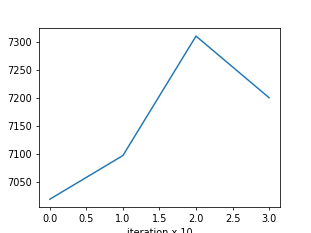

Final loss on Task 1: 
tensor(7200.0679, device='cuda:0')


In [13]:
%matplotlib notebook
plt.figure()
plt.plot(loss_rolling[1:])
plt.ylabel('loss over time')
plt.xlabel('iteration x 10')
plt.show()

print('Final loss on Task 1: ')
print(loss_rolling[-1])

In [24]:
del tensor
# del core
del factors
del rec

NameError: name 'factors' is not defined

In [ ]:
del optimizer
del loss

In [11]:
import gc
gc.collect()

111

In [14]:
torch.cuda.empty_cache()

<IPython.core.display.Javascript object>


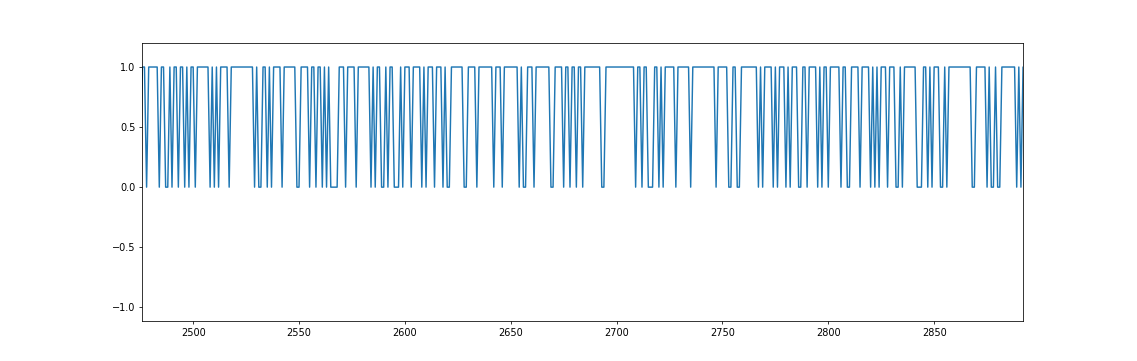

In [24]:
idx_batchSlices
plt.figure()
plt.plot(~np.in1d(np.arange(ntf_obj.factors3.cpu().detach().numpy().shape[0]) , idx_batchSlices))


<IPython.core.display.Javascript object>


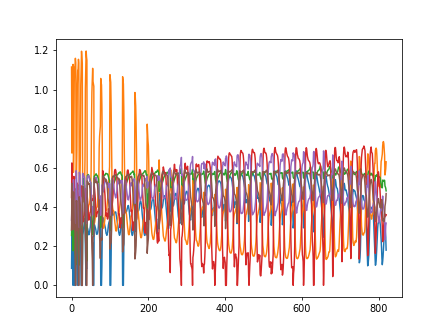

<IPython.core.display.Javascript object>


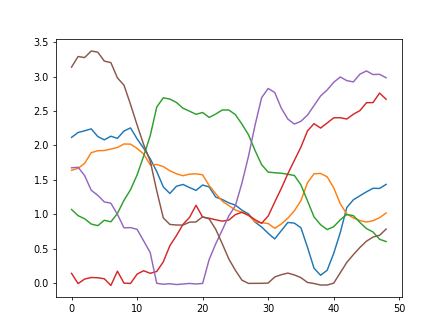

<IPython.core.display.Javascript object>


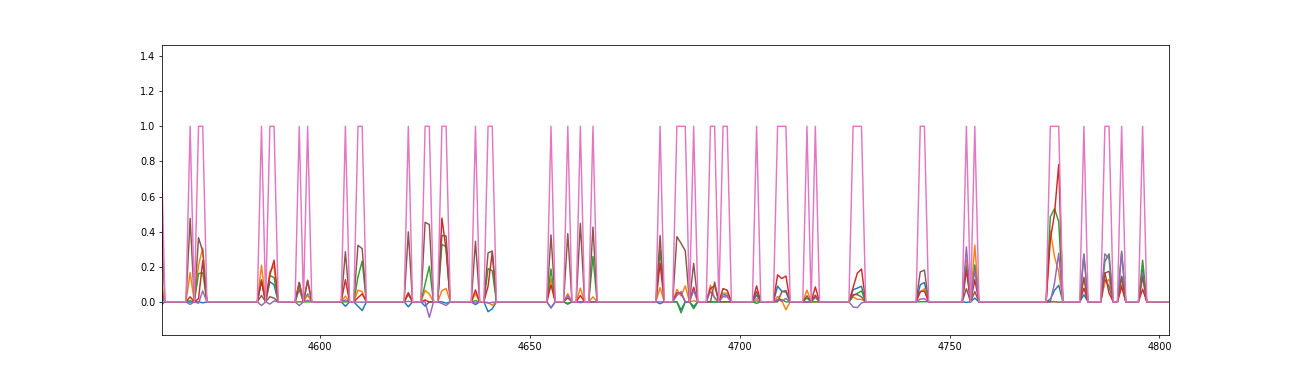

<IPython.core.display.Javascript object>


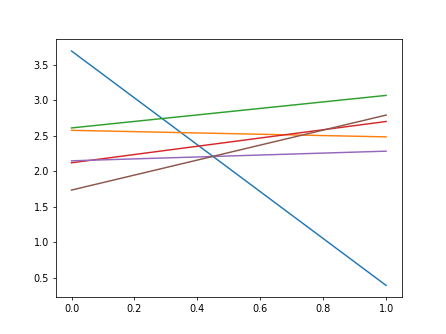

In [23]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.figure()
plt.plot(ntf_obj.factors1.cpu().detach().numpy())
plt.figure()
plt.plot(ntf_obj.factors2.cpu().detach().numpy())
plt.figure()
plt.plot(ntf_obj.factors3.cpu().detach().numpy()[:,:])
plt.plot(np.in1d(np.arange(ntf_obj.factors3.cpu().detach().numpy().shape[0]) , idx_batchSlices))
# plt.figure()
# plt.plot(factors_np[2])
plt.figure()
plt.plot(ntf_obj.factors4.cpu().detach().numpy())

In [45]:
# del tensor
# # del core
# del factors
# del rec

# del rec_error

# del optimizer
# del loss

# import gc
# gc.collect()

In [13]:
for i , (val , idx) in enumerate(dataloader_TensorData):
    print(idx)

tensor([ 9656, 26997, 24671, 17738, 28689, 24287, 10294, 23072, 24592, 15956,
         3466,  5046, 14350,   961, 19375, 20624, 21283, 14905, 25011,  6812,
        25875, 26875,  4772, 13843, 21808, 26255,  4281, 24897, 17449, 26912,
         8109, 18715, 14003, 21677, 13016,  5140, 10835, 21934, 14891, 17095,
        27892, 25530, 17915, 18214, 28794, 25613,  6779, 25097,  7050, 18549,
        11470,  3908,  9193,  3322,  6496, 13408,  1985, 18429,  7219, 10967,
        19619,  8506, 17880, 11009, 12911,  8669,  1083, 12742,  1037, 26905,
         8070, 28547, 29016,  6989, 17401, 17419, 24687, 10808, 19932, 13027,
         7076,  7848, 19660, 22032,  4549,   347, 28190,  4028, 25734,  5829,
        22181, 11078, 11842, 13091, 26035, 10737, 28823, 23269,   763,  9252])
tensor([ 8972, 29139, 20759, 22858, 14021, 18487, 26430,  9382, 26324, 10962,
         9360,  5452,   134,  6681, 27225, 17013, 14292, 27734,  2708, 20380,
        18692,  8346,  6030,  4349,  2822, 25968,  6986,  8851,

tensor([ 8233, 11679,  8067, 25598,  6286,  5716, 11507, 23877, 27674,  7943,
         6588,  2903, 18620,  8451,  1394, 22097,  5233, 13304,  6199,  2961,
        25440, 12453, 11215, 26891, 13724, 24722,  8566,  4328, 17010,  6521,
        13714, 12264,  6339,  5729, 20288,  8447, 21060,  2590, 17816, 26828,
         7513, 11592, 10382,  2378, 12452,  5690,  6590, 27111,  8125,   563,
        13596, 21782, 13648, 27308, 16754,  1441, 18080, 22907,  3955,  5370,
         5618,  3526,  1053,  4283,    15,  2494, 10134, 28647,  2207, 22394,
        25359, 23039, 14344, 22638, 13836, 26072, 15062, 13270, 25833,  4441,
        11259,  8050, 12419,  4450, 17799, 16522, 13005, 17643, 14861, 22429,
        18707, 25010, 22195, 15054,  5113, 23517, 24218,  4021, 21389, 13013])
tensor([15873,  8911,   896,  5891,  5014, 10900, 23492,   939, 26843, 23227,
        22334,  6335,  6239,  3902, 16860, 17319, 24054, 24195, 27305, 23992,
        18852,  4324,  1121, 20144,  2646,  9068, 13541,  7832,

KeyboardInterrupt: 

In [43]:
loss.grad

<ipython-input-43-09a6243c8d35>:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  loss.grad


In [17]:
class A(object):
    variable_A = 1
    variable_B = 2

    def functionA(self, param):
        return (param+self.variable_A)


a = A()
print(a.functionA(4))

5


In [22]:
torch.cuda.empty_cache()

In [51]:
val

tensor([[[[1.5383, 1.9270],
          [1.1318, 1.2638],
          [0.8545, 0.6889],
          ...,
          [1.2513, 0.8248],
          [1.8060, 0.6558],
          [2.2006, 0.7592]],

         [[2.7083, 1.3074],
          [1.0721, 0.5715],
          [1.0118, 0.5997],
          ...,
          [0.2126, 0.4137],
          [1.8151, 0.6528],
          [1.2027, 0.5154]],

         [[1.9241, 3.0639],
          [1.0701, 1.7260],
          [0.4973, 1.0777],
          ...,
          [0.7664, 2.7032],
          [0.5573, 2.8729],
          [0.1861, 1.7773]],

         ...,

         [[1.0890, 0.2193],
          [0.7108, 0.2897],
          [0.7099, 0.2628],
          ...,
          [0.5657, 0.2466],
          [0.4423, 0.1063],
          [0.2002, 0.1040]],

         [[1.3655, 0.6868],
          [0.7255, 0.4638],
          [0.5841, 0.3397],
          ...,
          [0.4488, 0.3504],
          [0.4912, 0.0142],
          [0.3191, 0.1735]],

         [[1.4833, 1.2891],
          [0.7128, 0.6668],
    

In [62]:
Y_ = ntf_obj()
#         loss = tl.norm((Y_ - goal_tensor), 2)
loss = tl.norm((Y_ - val), 2)

#         # squared l2 penalty on the factors of the decomposition
#         for param in ntf_obj.parameters():
#     #         loss = loss + penalty_L2 * param.data.pow(2).sum()
#     #         loss = loss + penalty_L2 * param.data.abs().sum()

#             l1_regularization = penalty_L1 * torch.norm(param.data, 1)
#             l2_regularization = penalty_L2 * torch.norm(param.data, 2)
#             loss = loss + l1_regularization + l2_regularization


ntf_obj.zero_grad() # need to clear the old gradients
loss.backward(retain_graph=True)
optimizer.step()

In [210]:
type(tuple(ntf_obj.factors1))

tuple

In [73]:
1e4

10000.0

In [ ]:
# import time

# n_iter = 1000
# lr = 0.05
# penalty = 0.1

# prox_plus = nn.Threshold(0,0) ## to make all output postive 

# optimizer = torch.optim.Adam(factors, lr=lr)

# tic = time.time()
# for i in range(1, n_iter):
#     print(f'hi {i}')
#     # Important: do not forget to reset the gradients
#     optimizer.zero_grad()

#     # Reconstruct the tensor from the decomposed form
# #     rec = tucker_to_tensor((core, factors))
#     rec = prox_plus(tl.cp_tensor.cp_to_tensor((weights, factors)))

#     # squared l2 loss
# #     loss = (tl.norm(rec - tensor, 2)).cpu().detach()
#     loss = tl.norm((rec - tensor), 2)

#     # squared l2 penalty on the factors of the decomposition
#     for f in factors:
#         loss = loss + penalty * f.pow(2).sum()

#     loss.backward()
#     optimizer.step()
    
# #     factors = np.abs(factors)

#     if i % 1 == 0:
#         toc = time.time()
#         print(round(toc-tic,2))
#         rec_error = tl.norm(rec.data - tensor.data, 2)/tl.norm(tensor.data, 2)
#         print("Epoch {},. Rec. error: {}".format(i, rec_error))
#         tic = time.time()

In [179]:
# [(test[0] == b_).any() for b_ in test[0]]
hey = [(test[0][:,0,0,0] == test[0][i,0,0,0]).sum() for i in range(test[1].shape[0])]
hey
    
# if any([(a == d_).all() for d_ in d]):
#     print('a in d')

[tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 ten